In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import missingno as msno

In [3]:
shop_sales = pd.read_csv("./data/shop_sales.csv")
sales_dates = pd.read_csv("./data/shop_sales_dates.csv")
price = pd.read_csv("./data/shop_sales_prices.csv")

### Tools

In [4]:
def plot_histogram_of_unique_values(unique_groups, counts):
    # Plot the bar chart of item counts
    plt.figure(figsize=(12, 6))
    plt.bar(unique_groups, counts)
    plt.title('Sales Count for Each Item')
    plt.xlabel('Item ID')
    plt.ylabel('Number of Sales')
    
    # Rotate the X-axis labels by 45 degrees
    plt.xticks(rotation=45)
    
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to prevent clipping of labels
    plt.show()

## Intro

Let's start with the shape

In [5]:
def check_shapes_of_dataframes(*dfs):
    for idx, df in enumerate(dfs, 1):
        rows, cols = df.shape
        print(f"DataFrame {idx} has {rows} rows and {cols} columns.")

check_shapes_of_dataframes(shop_sales, sales_dates, price)

DataFrame 1 has 81855 rows and 4 columns.
DataFrame 2 has 1819 rows and 14 columns.
DataFrame 3 has 11141 rows and 4 columns.


First, let's check the NaNs values

In [6]:
def check_nans_in_dataframes(*dfs):
    for idx, df in enumerate(dfs, 1):
        nan_counts = df.isna().sum()
        if nan_counts.any():
            print(f"DataFrame {idx} has NaN values in the following columns:")
            for col, count in nan_counts.items():
                if count > 0:
                    print(f" - Column '{col}' has {count} NaN values.")
        else:
            print(f"DataFrame {idx} has no NaN values.")

check_nans_in_dataframes(shop_sales, sales_dates, price)

DataFrame 1 has no NaN values.
DataFrame 2 has NaN values in the following columns:
 - Column 'event_name_1' has 1673 NaN values.
 - Column 'event_type_1' has 1673 NaN values.
 - Column 'event_name_2' has 1815 NaN values.
 - Column 'event_type_2' has 1815 NaN values.
DataFrame 3 has no NaN values.


OK, we will return to the NaN values in the future, but for now, let's take a look at the shop_sales

## Shop sales

In [7]:
shop_sales.head()

,item_id,store_id,date_id,cnt
0,STORE_2_085,STORE_2,1,3
1,STORE_2_085,STORE_2,2,8
2,STORE_2_085,STORE_2,3,0
3,STORE_2_085,STORE_2,4,3
4,STORE_2_085,STORE_2,5,0


As we can see here, we have the groups of the items. Let's group by item and store. But first, let's plot the histogram of the sales

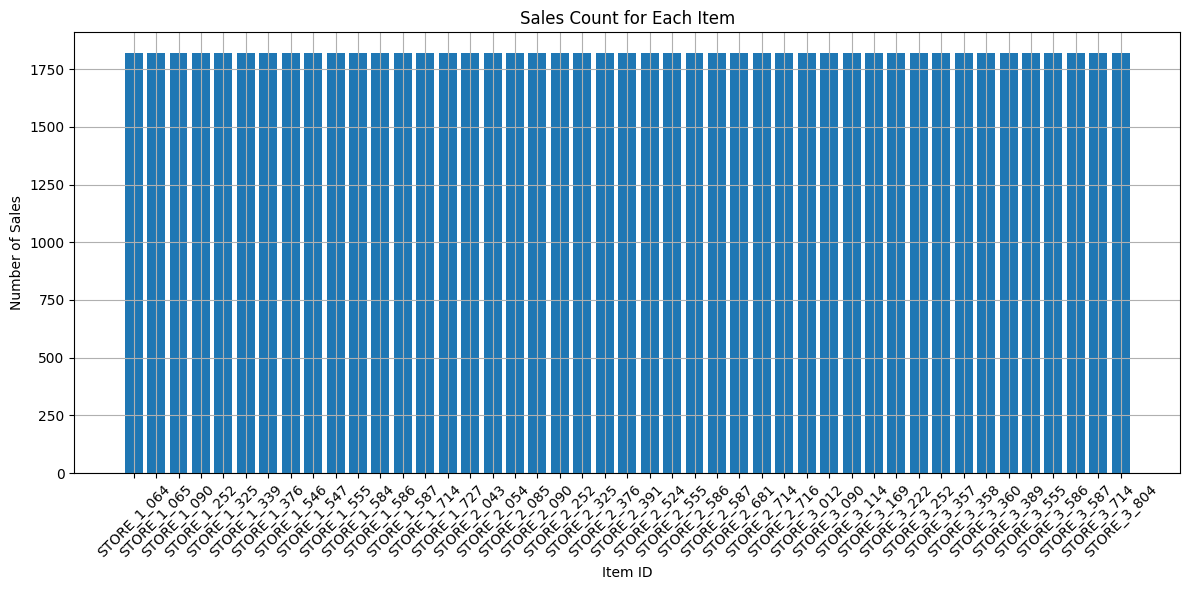

In [8]:
plot_histogram_of_unique_values(*np.unique(shop_sales["item_id"], return_counts=True))

Let's remove the 'store' prefix and count the unique items

In [9]:
pattern = r'^STORE_\d+_'
shop_sales['item_id_without_store'] = shop_sales['item_id'].apply(lambda x: re.sub(pattern, '', x))
shop_sales.head()

,item_id,store_id,date_id,cnt,item_id_without_store
0,STORE_2_085,STORE_2,1,3,085
1,STORE_2_085,STORE_2,2,8,085
2,STORE_2_085,STORE_2,3,0,085
3,STORE_2_085,STORE_2,4,3,085
4,STORE_2_085,STORE_2,5,0,085


Now, we can plot the histogram for the unique items without grouping them by stores

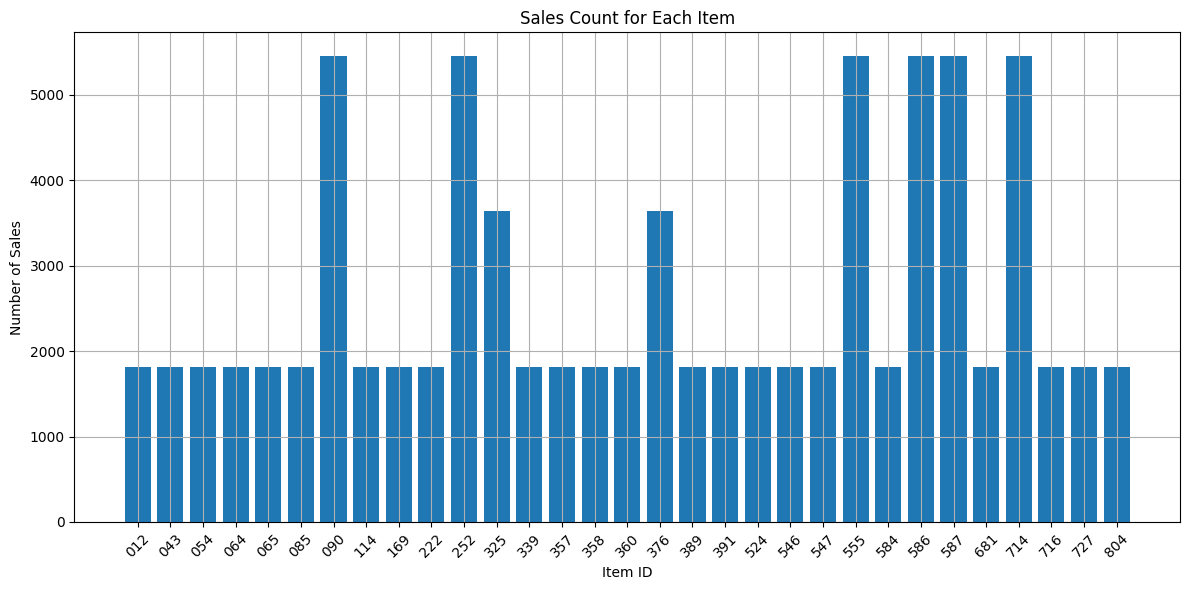

In [10]:
plot_histogram_of_unique_values(*np.unique(shop_sales["item_id_without_store"], return_counts=True))

OK, it doesn't provide useful information; we just confirmed that some of the products were sold in different stores. Let's move further and connect the shop sales with the time data

### Sales Dates

In [11]:
sales_dates.head()

,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,date_id,CASHBACK_STORE_1,CASHBACK_STORE_2,CASHBACK_STORE_3
0,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,1,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,2,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,3,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,4,0,1,1
4,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,5,1,1,0


In [12]:
data = pd.merge(shop_sales, sales_dates, on='date_id', how='left')
data['date'] = pd.to_datetime(data['date'])

Let's group by a single item and visualize the time series for the first item

In [15]:
import plotly.graph_objs as go

def plot_time_series_plotly(dataframe, date_column_name, sales_column_name, downsample_interval='M'):
    """
    This function plots time series data using Plotly with optional downsampling.
    
    Args:
    dataframe: DataFrame containing the data.
    date_column_name: Name of the column containing the datetime data.
    sales_column_name: Name of the column containing the sales data.
    downsample_interval: Interval for downsampling ('D' for daily, 'W' for weekly, 'M' for monthly). Defaults to 'M' (monthly).
    """
    dataframe[date_column_name] = pd.to_datetime(dataframe[date_column_name])

    # Downsampling the data to reduce the number of points for clearer visualization
    if downsample_interval:
        dataframe = dataframe.resample(downsample_interval, on=date_column_name).sum().reset_index()

    fig = go.Figure()

    # Add the trace for the sales data
    fig.add_trace(go.Scatter(x=dataframe[date_column_name], 
                             y=dataframe[sales_column_name], 
                             mode='lines+markers', 
                             marker=dict(size=3),  # Smaller markers for clarity
                             line=dict(width=1),
                             name=sales_column_name))

    # Update the layout for better visualization
    fig.update_layout(title=f'{sales_column_name} Over Time (Downsampled)',
                      xaxis_title='Date',
                      yaxis_title=f'{sales_column_name}',
                      xaxis_rangeslider_visible=True,  # Add range slider for easier zooming
                      template="plotly_white",
                      autosize=False,
                      width=1000, height=600)

    # Show the plot
    fig.show()

# Example of how to call the function (assuming 'df' is your dataframe)
plot_time_series_plotly(data, 'date', 'cnt', downsample_interval='W')  # You can change on 'D' - daily , 'M' - mothly and 'W' - weekly downsampling